In [ ]:
! pip install pykeops

In [8]:
import time
import torch
from matplotlib import pyplot as plt
from pykeops.torch import LazyTensor

use_cuda = torch.cuda.is_available()
dtype = 'float32' if use_cuda else 'float64'
torchtype = {'float32': torch.float32, 'float64': torch.float64}

In [9]:
def KMeans(x, K=10, Niter=10, verbose=True):
    N, D = x.shape  # Number of samples, dimension of the ambient space

    # K-means loop:
    # - x  is the point cloud,
    # - cl is the vector of class labels
    # - c  is the cloud of cluster centroids
    start = time.time()
    c = x[:K, :].clone()  # Simplistic random initialization
    x_i = LazyTensor(x[:, None, :])  # (Npoints, 1, D)

    for i in range(Niter):

        c_j = LazyTensor(c[None, :, :])  # (1, Nclusters, D)
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances
        cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

        Ncl = torch.bincount(cl).type(torchtype[dtype])  # Class weights
        for d in range(D):  # Compute the cluster centroids with torch.bincount:
            c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl

    end = time.time()

    if verbose:
        print("K-means example with {:,} points in dimension {:,}, K = {:,}:".format(N, D, K))
        print('Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n'.format(
                Niter, end - start, Niter, (end-start) / Niter))

    return cl, c

## k means in 2D

In [10]:
N, D, K = 10000, 2, 50

In [11]:
x = torch.randn(N, D, dtype=torchtype[dtype]) / 6 + .5

In [12]:
cl, c = KMeans(x, K)

Compiling libKeOpstorch94a18af902 in /home/jovyan/.cache/pykeops-1.4.1-cpython-36/build-libKeOpstorch94a18af902:
       formula: ArgMin_Reduction(Sum(Square((Var(0,2,0) - Var(1,2,1)))),0)
       aliases: Var(0,2,0); Var(1,2,1); 
       dtype  : float32
... Done.
K-means example with 10,000 points in dimension 2, K = 50:
Timing for 10 iterations: 32.76767s = 10 x 3.27677s



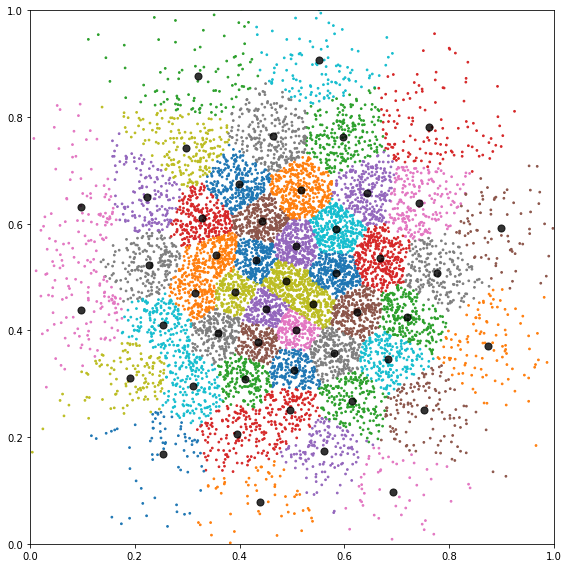

In [14]:
plt.figure(figsize=(8,8))
plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=cl.cpu(), s= 30000 / len(x), cmap="tab10")
plt.scatter(c[:, 0].cpu(), c[:, 1].cpu(), c='black', s=50, alpha=.8)
plt.axis([0,1,0,1]) ; plt.tight_layout() ; plt.show()

## k means in dimension 100

In [15]:
if use_cuda:
    N, D, K = 1000000, 100, 1000
    x = torch.randn(N, D, dtype=torchtype[dtype])
    cl, c = KMeans(x, K)

Compiling libKeOpstorch3ba0e30d84 in /home/jovyan/.cache/pykeops-1.4.1-cpython-36/build-libKeOpstorch3ba0e30d84:
       formula: ArgMin_Reduction(Sum(Square((Var(0,100,0) - Var(1,100,1)))),0)
       aliases: Var(0,100,0); Var(1,100,1); 
       dtype  : float32
... Done.
K-means example with 1,000,000 points in dimension 100, K = 1,000:
Timing for 10 iterations: 90.65166s = 10 x 9.06517s



In [25]:
from sklearn import datasets
import pandas as pd

iris = datasets.load_iris()

labels = pd.DataFrame(iris.target)
labels.columns=['labels']
data = pd.DataFrame(iris.data)
data.columns=['Sepal length','Sepal width','Petal length','Petal width']
data = pd.concat([data,labels],axis=1)
feature = data[ ['Sepal length','Sepal width']]
feature.head()

Sepal length  Sepal width
0           5.1          3.5
1           4.9          3.0
2           4.7          3.2
3           4.6          3.1
4           5.0          3.6

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot  as plt
import seaborn as sns

# create model and prediction

model = KMeans(n_clusters=3,algorithm='auto')
model.fit(feature)
predict = pd.DataFrame(model.predict(feature))
predict.columns=['predict']

In [27]:
# concatenate labels to df as a new column

r = pd.concat([feature,predict],axis=1)

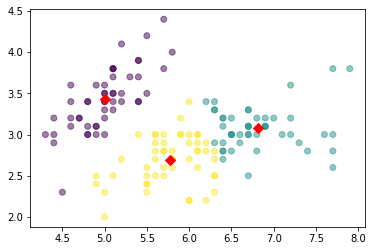

In [30]:
plt.scatter(r['Sepal length'],r['Sepal width'],c=r['predict'],alpha=0.5)
centers = pd.DataFrame(model.cluster_centers_,columns=['Sepal length','Sepal width'])
center_x = centers['Sepal length']
center_y = centers['Sepal width']
plt.scatter(center_x,center_y,s=50,marker='D',c='r')
plt.show()

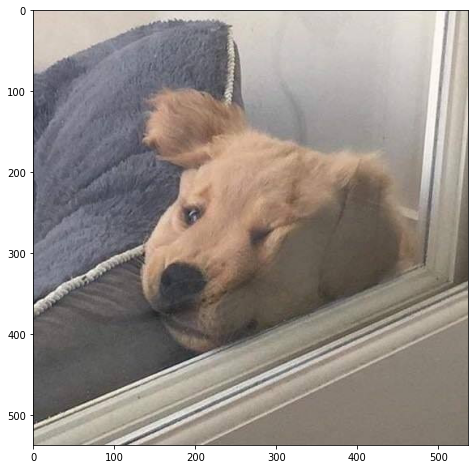

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import cluster
import imageio

img = imageio.imread("dog.jpg")
plt.figure(figsize = (15,8))
plt.imshow(img)

In [60]:
img.shape

(537, 537, 3)

In [61]:
x, y, z = img.shape
image_2d = img.reshape(x*y, z)
image_2d.shape

(288369, 3)

In [62]:
kmeans_cluster = cluster.KMeans(n_clusters=7)
kmeans_cluster.fit(image_2d)

cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

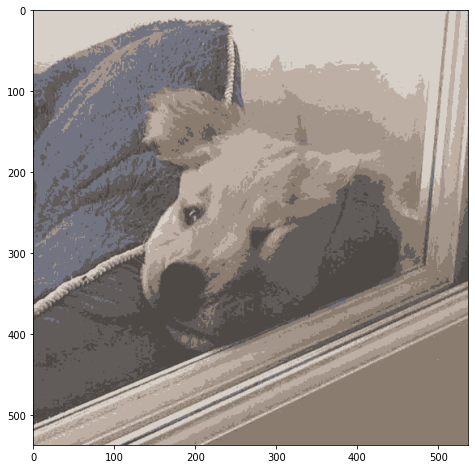

In [63]:
plt.figure(figsize = (15,8))
plt.imshow((cluster_centers[cluster_labels].reshape(x, y, z)).astype(np.uint8))

In [64]:
cluster_centers

array([[138.71663417, 125.09734789, 112.12862715],
       [189.62378723, 175.9849399 , 163.88287397],
       [ 97.79324756,  92.16445777,  90.62890587],
       [163.170283  , 149.43757622, 137.99653084],
       [115.84429099, 116.23742999, 129.46696792],
       [ 78.59163721,  73.13687298,  69.07178311],
       [214.211826  , 208.16311539, 201.80859599]])

In [65]:
cluster_labels

array([6, 6, 6, ..., 0, 0, 0], dtype=int32)

In [68]:
cluster_centers[cluster_labels]

array([[214.211826  , 208.16311539, 201.80859599],
       [214.211826  , 208.16311539, 201.80859599],
       [214.211826  , 208.16311539, 201.80859599],
       ...,
       [138.71663417, 125.09734789, 112.12862715],
       [138.71663417, 125.09734789, 112.12862715],
       [138.71663417, 125.09734789, 112.12862715]])

NameError: name 'color' is not defined

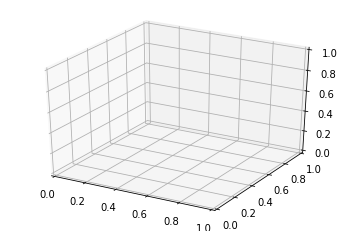

In [70]:
x = []
y = []
z = []

for i in range(cluster_centers[cluster_labels].shape[0]):
    x.append(cluster_centers[cluster_labels][i][0])
    y.append(cluster_centers[cluster_labels][i][1])
    z.append(cluster_centers[cluster_labels][i][2])

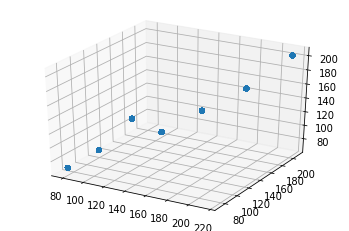

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
plt.show()

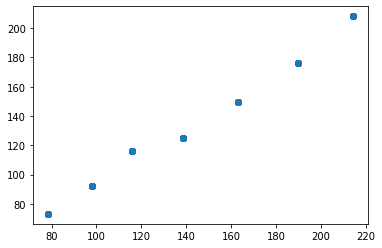

In [75]:
plt.scatter(x,y)

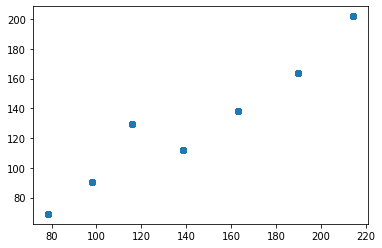

In [76]:
plt.scatter(x,z)

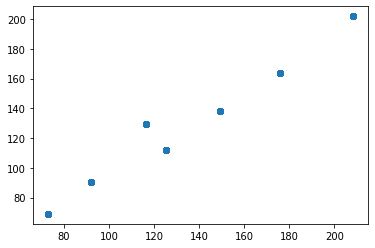

In [77]:
plt.scatter(y,z)

Automatically created module for IPython interactive environment


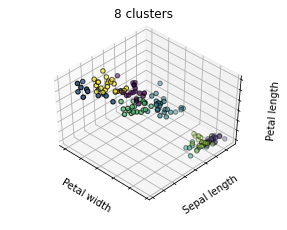

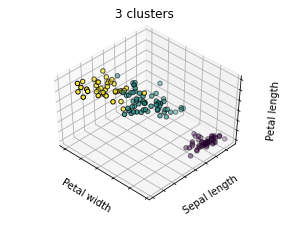

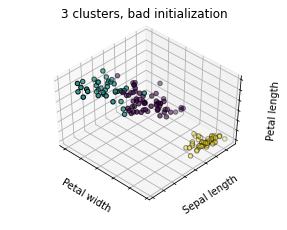

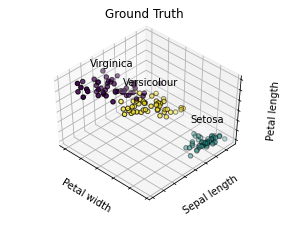

In [46]:
print(__doc__)


# Code source: GaÃ«l Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
# Though the following import is not directly being used, it is required
# for 3D projection to work
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import datasets

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target

estimators = [('k_means_iris_8', KMeans(n_clusters=8)),
              ('k_means_iris_3', KMeans(n_clusters=3)),
              ('k_means_iris_bad_init', KMeans(n_clusters=3, n_init=1,
                                               init='random'))]

fignum = 1
titles = ['8 clusters', '3 clusters', '3 clusters, bad initialization']
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2],
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Petal width')
    ax.set_ylabel('Sepal length')
    ax.set_zlabel('Petal length')
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1

# Plot the ground truth
fig = plt.figure(fignum, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

for name, label in [('Setosa', 0),
                    ('Versicolour', 1),
                    ('Virginica', 2)]:
    ax.text3D(X[y == label, 3].mean(),
              X[y == label, 0].mean(),
              X[y == label, 2].mean() + 2, name,
              horizontalalignment='center',
              bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
ax.set_title('Ground Truth')
ax.dist = 12

fig.show()